In [2]:
# imports
import tensorflow as tf
import pretty_midi as pm
import matplotlib.pyplot as plt
import mido as m
import numpy as np
from basic_pitch.inference import predict
from basic_pitch import ICASSP_2022_MODEL_PATH
basic_pitch_model = tf.saved_model.load(str(ICASSP_2022_MODEL_PATH))

In [2]:
pm_data = pm.PrettyMIDI("C:\\Users\\Tim\\Documents\\GitHub\\purdue-AIMA-basic-pitch-testing\\Tim\'s songs\\Blind Composition Render\\blind comp render E-PIANO ONLY_basic_pitch.mid")
midi = m.MidiFile("C:\\Users\\Tim\\Documents\\GitHub\\purdue-AIMA-basic-pitch-testing\\Tim\'s songs\\Blind Composition Render\\blind comp render E-PIANO ONLY_basic_pitch.mid")
pred_data = pm.PrettyMIDI("C:\\Users\\Tim\\Documents\\GitHub\\purdue-AIMA-basic-pitch-testing\\Tim\'s songs\Blind Composition Render\\Further Experimentation\\blind comp render PREDICTED clean.mid")

# Environment variables
n_shingle = 3
round_place = 4

std_onset = 0.3;
std_frame = 0.2;
std_min_note_len = 127.70
std_min_freq = None;
std_max_freq = None;

In [131]:
def plot(in_vals, out_vals, title, axis_in, axis_out):
    fig, ax = plt.subplots()
    ax.plot(in_vals, out_vals)
    ax.set_xlabel(axis_in)
    ax.set_ylabel(axis_out)
    ax.set_title(title)
    ax.grid(True)
    plt.show()
    
def dim(a):
    if not type(a) == list:
        return []
    if (len(a) == 0):
        return [1]
    return [len(a)] + dim(a[0])

# Returns the intersection of two lists
def intersection(A, B):
    interSet = []
    for a in A:
        if a in B and not a in interSet:
            interSet.append(a)
    return interSet

# Returns the union of two lists
def union(A, B):
    unionSet = []
    for a in A:
        unionSet.append(a)
    for b in B:
        if not (b in unionSet):
            unionSet.append(b)
    return unionSet

# Returns a list of pitch-separated start times for Mido input
def startTimesPitchedMido(midi, round_place, octave_ignored):
    number_notes = 128
    if (octave_ignored):
        number_notes = 12
    first_note_start_time = -1.0
    note_startTimes = [None] * number_notes
    for i in range(0, number_notes):
        note_startTimes[i] = []
    currentTime = 0.0
    triggered = False
    # Grab list of notes sorted by pitch (either octave-agnostic or dependent)
    for i in midi:
        triggered = True
        if i.type == 'note_on' or i.type == 'note_off':
            if (octave_ignored):
                note_startTimes[i.note % 12].append(currentTime + i.time)
            else:
                note_startTimes[i.note].append(currentTime + i.time)
            if (first_note_start_time == -1.0): first_note_start_time = i.time
            currentTime += i.time
    # Adjust start time to be 0
    if triggered:
        for i in range(0, len(note_startTimes)):
            for j in range(0, len(note_startTimes[i])):
                note_startTimes[i][j] -= first_note_start_time
                note_startTimes[i][j] = round(note_startTimes[i][j], round_place)
    # Remove duplicates
    for i in range(0, len(note_startTimes)):
        noDuplicatesList = []
        for j in range(0, len(note_startTimes[i])):
            if not note_startTimes[i][j] in noDuplicatesList:
                noDuplicatesList.append(note_startTimes[i][j])
        note_startTimes[i] = noDuplicatesList
    return note_startTimes

# Returns a list of pitch-separated start times for PrettyMIDI input
def startTimesPitchedPretty(midi, round_place, octave_ignored):
    number_notes = 128
    if (octave_ignored):
        number_notes = 12
    first_note_start_time = -1.0
    note_startTimes = [None] * number_notes
    for i in range(0, number_notes):
        note_startTimes[i] = []
    triggered = False
    # Grab list of notes sorted by pitch (either octave-agnostic or dependent)
    for inst in midi.instruments:
        for note in inst.notes:
            triggered = True
            if (octave_ignored):
                note_startTimes[note.pitch % 12].append(note.start)
            else:
                note_startTimes[note.pitch].append(note.start)
            if (first_note_start_time == -1.0): first_note_start_time = note.start
    # Adjust start time to be 0
    if triggered:
        for i in range(0, len(note_startTimes)):
            for j in range(0, len(note_startTimes[i])):
                note_startTimes[i][j] -= midi.instruments[0].notes[0].start
                note_startTimes[i][j] = round(note_startTimes[i][j], round_place)
    # Remove duplicates
    for i in range(0, len(note_startTimes)):
        noDuplicatesList = []
        for j in range(0, len(note_startTimes[i])):
            if not note_startTimes[i][j] in noDuplicatesList:
                noDuplicatesList.append(note_startTimes[i][j])
        note_startTimes[i] = noDuplicatesList
    return note_startTimes

# Returns a list of shingles of elements in a 1D list
def nShingle(myList, n):
    if n > len(myList): return []
    if n == len(myList): return [myList]
    shingleList = []
    for i in range(0, len(myList) - n + 1):
        shingle = []
        for j in range(i, i + n):
            shingle.append(myList[j])
        shingleList.append(shingle)
    return shingleList

# Returns a list of shingles of a 2D list
def nShinglePitched(my2Dlist, n):
    fullList = [None] * len(my2Dlist)
    for i in range(0, len(my2Dlist)):
        fullList[i] = nShingle(my2Dlist[i], n)
    return fullList

# Returns a pitch-adjusted similarity coefficient of two MIDI files
def similarityPitchedDual(midiMido, midiPretty, n_shingle, round_place, octave_ignored):
    startTimesPitched1 = startTimesPitchedMido(midiMido, round_place, octave_ignored)
    startTimesPitched2 = startTimesPitchedPretty(midiPretty, round_place, octave_ignored)
    shinglesPitched1 = nShinglePitched(startTimesPitched1, n_shingle)
    shinglesPitched2 = nShinglePitched(startTimesPitched2, n_shingle)
    weighted_sum = 0.0
    total_shingles = 0.0
    for i in range(0, len(startTimesPitched1)):
        sim_denominator = (float)(len(union(shinglesPitched1[i], shinglesPitched2[i])))
        if not sim_denominator == 0:
            sim_numerator = (float)(len(intersection(shinglesPitched1[i], shinglesPitched2[i])))
            similarity = sim_numerator / sim_denominator
            shingles_added = (len(shinglesPitched1[i]) + len(shinglesPitched2[i]))
            weighted_sum += similarity * shingles_added
            total_shingles += shingles_added
    score = pow(weighted_sum / total_shingles, 1/4)
    return score

def generate_similarity(onset, frame, min_note_len, min_freq, max_freq):
    model_output, midi_data, note_events = predict(
        "C:\\Users\\Tim\\Documents\\GitHub\\purdue-AIMA-basic-pitch-testing\\Tim\'s songs\\Blind Composition Render\\blind comp render E-PIANO ONLY.mp3",
        basic_pitch_model,
        onset,
        frame,
        min_note_len,
        min_freq,
        max_freq
    )
    return similarityPitchedClosest(midi, midi_data, round_place, False)

def generate_arrays():
    # onset vary
    in_vals = list(np.linspace(0.01, 0.05 * 20 + 0.01, 20))
    out_vals = []
    for i in in_vals:
        out_vals.append(generate_similarity(i, std_frame, std_min_note_len, std_min_freq, std_max_freq))
    plot(in_vals, out_vals, "Varying onset", "Onset coeff.", "Note similarity")
    
    # frame vary
    in_vals = list(np.linspace(0.01, 0.05 * 20 + 0.01, 20))
    out_vals = []
    for i in in_vals:
        out_vals.append(generate_similarity(std_onset, i, std_min_note_len, std_min_freq, std_max_freq))
    plot(in_vals, out_vals, "Varying frames", "Frame coeff.", "Note similarity")
        
    # min_note_len vary
    in_vals = list(np.linspace(5, 10 * 20 + 5, 20))
    out_vals = []
    for i in in_vals:
        out_vals.append(generate_similarity(std_onset, std_frame, i, std_min_freq, std_max_freq))
    plot(in_vals, out_vals, "Varying minimum note length", "Minimum note length (ms)", "Note similarity")
        
    # min_freq vary
    in_vals = list(np.linspace(20, 21 * 20, 20))
    out_vals = []
    for i in in_vals:
        out_vals.append(generate_similarity(std_onset, std_frame, std_min_note_len, i, std_max_freq))
    plot(in_vals, out_vals, "Varying minimum freq.", "Min. freq. (Hz)", "Note similarity")
        
    # max_freq vary
    in_vals = list(np.linspace(10000, -400 * 20 + 10000, 20))
    out_vals = []
    for i in in_vals:
        out_vals.append(generate_similarity(std_onset, std_frame, std_min_note_len, std_min_freq, i))
    plot(in_vals, out_vals, "Varying maximum freq.", "Max. freq. (Hz)", "Note similarity")


In [125]:
def closestTimePlayedScore(startTimesOrig, startTimesPred):
    if (len(startTimesOrig) != len(startTimesPred)): return 0
    sumRMSdiffs = 0.0
    for note in range(0, len(startTimesOrig)):
        noteTimesOrig = startTimesOrig[note]
        noteTimesPred = startTimesPred[note]
        #print(noteTimesOrig)
        #print(noteTimesPred)
        diff = 0.0
        if (len(noteTimesOrig) == 0) and (len(noteTimesPred) == 0):
            diff = 0.0
        elif (len(noteTimesPred) == 0):
            diff = 1.0
        else: 
            for time in noteTimesOrig:
                minDiff = 100000.0
                for i in range(0, len(noteTimesPred)):
                    if (abs(noteTimesPred[i] - time) < minDiff):
                        minDiff = abs(noteTimesPred[i] - time)
                #print(minDiff)
                diff += pow(minDiff, 2)
        #print(diff)
        sumRMSdiffs += diff
    notes = 0
    for i in range(0, len(startTimesOrig)):
        for j in range(0, len(startTimesOrig[i])):
            notes += 1
    sumRMSdiffs /= notes
    sumRMSdiffs = pow(sumRMSdiffs, 1/2)
    return sumRMSdiffs

# Returns a pitch-adjusted similarity coefficient of two MIDI files
def similarityPitchedClosest(midiMido, midiPretty, round_place, octave_ignored):
    startTimesPitched1 = startTimesPitchedMido(midiMido, round_place, octave_ignored)
    startTimesPitched2 = startTimesPitchedPretty(midiPretty, round_place, octave_ignored)
    return closestTimePlayedScore(startTimesPitched1, startTimesPitched2)

similarityPitchedClosest(midi, pred_data, round_place, False)

8.286890662157097

In [126]:
def closestTimePlayedWithinRange(startTimesOrig, startTimesPred, tolerance):
    if (len(startTimesOrig) != len(startTimesPred)): return 0
    sumDiffs = 0.0
    for note in range(0, len(startTimesOrig)):
        noteTimesOrig = startTimesOrig[note]
        noteTimesPred = startTimesPred[note]
        #print(noteTimesOrig)
        #print(noteTimesPred)
        diff = 0.0
        if (len(noteTimesOrig) == 0) or (len(noteTimesPred) == 0):
            diff = 0.0
        else: 
            for time in noteTimesOrig:
                minDiff = 100000.0
                for i in range(0, len(noteTimesPred)):
                    if (abs(noteTimesPred[i] - time) < minDiff):
                        minDiff = abs(noteTimesPred[i] - time)
                #print(minDiff)
                if (minDiff < tolerance):
                    diff = 1.0
        sumDiffs += diff
    notes = 0
    for i in range(0, len(startTimesOrig)):
        for j in range(0, len(startTimesOrig[i])):
            notes += 1
    sumDiffs /= notes
    return sumDiffs

# Returns a pitch-adjusted similarity coefficient of two MIDI files
def similarityPitchedWithinRange(midiMido, midiPretty, round_place, octave_ignored, tolerance):
    startTimesPitched1 = startTimesPitchedMido(midiMido, round_place, octave_ignored)
    startTimesPitched2 = startTimesPitchedPretty(midiPretty, round_place, octave_ignored)
    return closestTimePlayedWithinRange(startTimesPitched1, startTimesPitched2, tolerance)

similarityPitchedWithinRange(midi, pred_data, round_place, False, 100)

0.022674418604651164

Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-A

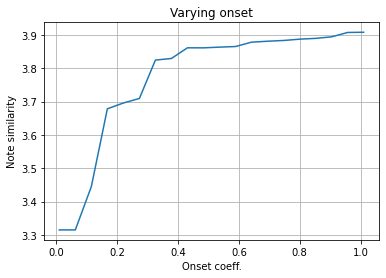

Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-A

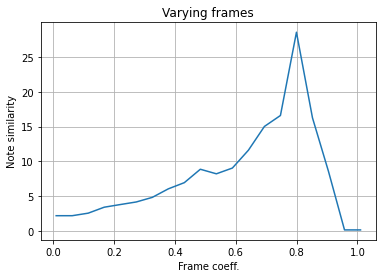

Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-A

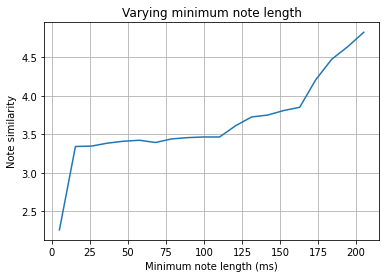

Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-A

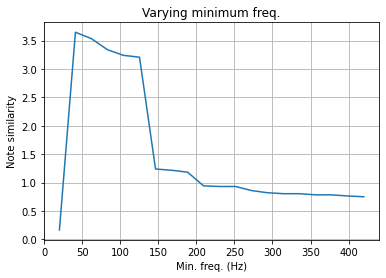

Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-A

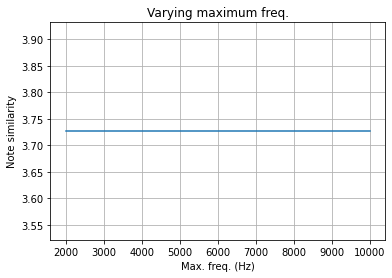

In [127]:
generate_arrays()

Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-A

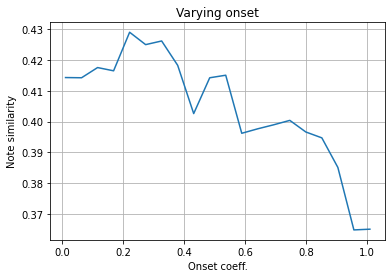

Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-A

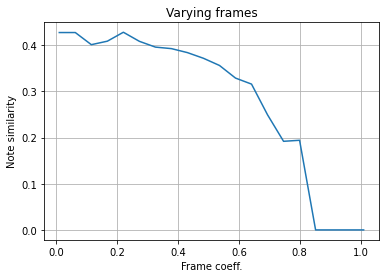

Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-A

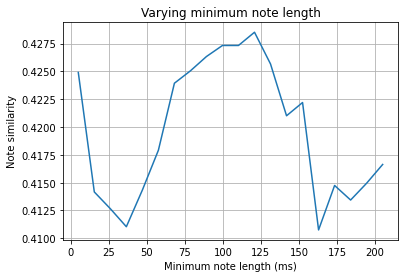

Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-A

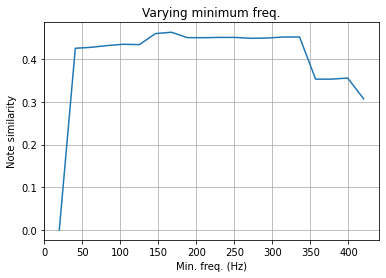

Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-A

C:\Users\Tim\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\convert.py:740: RuntimeWarning: invalid value encountered in log2
  return 12 * (np.log2(np.asanyarray(frequencies)) - np.log2(440.0)) + 69


ValueError: cannot convert float NaN to integer

In [130]:
def generate_similarity(onset, frame, min_note_len, min_freq, max_freq):
    model_output, midi_data, note_events = predict(
        "C:\\Users\\Tim\\Documents\\GitHub\\purdue-AIMA-basic-pitch-testing\\Tim\'s songs\\Blind Composition Render\\blind comp render E-PIANO ONLY.mp3",
        basic_pitch_model,
        onset,
        frame,
        min_note_len,
        min_freq,
        max_freq
    )
    return similarityPitchedDual(midi, midi_data, n_shingle, 0, False)

generate_arrays()

Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-A

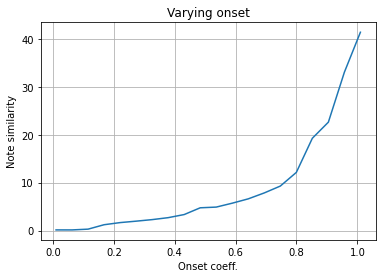

Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-A

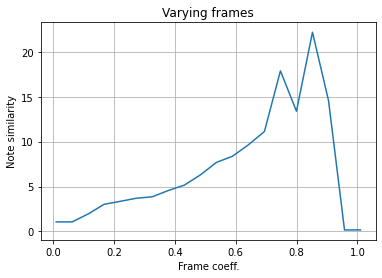

Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-A

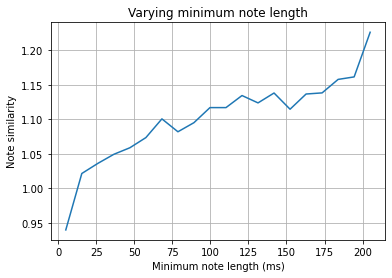

Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-A

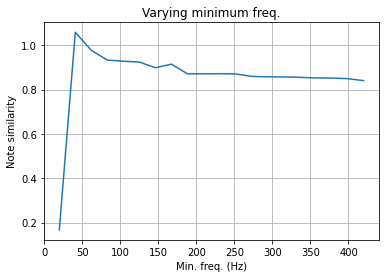

Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-AIMA-basic-pitch-testing\Tim's songs\Blind Composition Render\blind comp render E-PIANO ONLY.mp3...
Predicting MIDI for C:\Users\Tim\Documents\GitHub\purdue-A

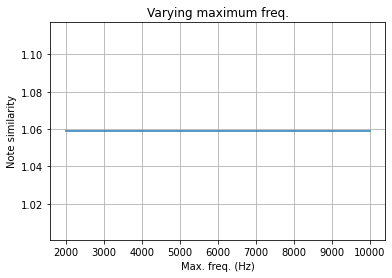

In [134]:
std_onset = 0.15
std_frame = 0.05
std_min_note_len = 50
std_min_freq = None
std_max_freq = None

def generate_similarity(onset, frame, min_note_len, min_freq, max_freq):
    model_output, midi_data, note_events = predict(
        "C:\\Users\\Tim\\Documents\\GitHub\\purdue-AIMA-basic-pitch-testing\\Tim\'s songs\\Blind Composition Render\\blind comp render E-PIANO ONLY.mp3",
        basic_pitch_model,
        onset,
        frame,
        min_note_len,
        min_freq,
        max_freq
    )
    return similarityPitchedClosest(midi, midi_data, round_place, False)


generate_arrays()

In [2]:
# imports
import tensorflow as tf
import pretty_midi as pm
import matplotlib.pyplot as plt
import mido as m
import numpy as np
from basic_pitch.inference import predict
from basic_pitch import ICASSP_2022_MODEL_PATH
basic_pitch_model = tf.saved_model.load(str(ICASSP_2022_MODEL_PATH))

In [7]:
std_onset = 0.3
std_frame = 0.2
std_min_note_len = 50
std_min_freq = None
std_max_freq = 3000

filestr1 = "C:\\Users\\Tim\\Downloads\\03. Flamenco from Suite espagnole No. 1.wav"
filestr2 = "C:\\Users\\Tim\\Downloads\\05. Suite No. 3 BWV 1009 C Major (Prelude).wav"
outstr1 = "C:\\Users\\Tim\\Downloads\\flamenco.mid"
outstr2 = "C:\\Users\\Tim\\Downloads\\suite.mid"

model_output, midi_data, note_events = predict(
        filestr1,
        basic_pitch_model,
        std_onset,
        std_frame,
        std_min_note_len,
        std_min_freq,
        std_max_freq
)
midi_data.write(outstr1)

model_output, midi_data, note_events = predict(
        filestr2,
        basic_pitch_model,
        std_onset,
        std_frame,
        std_min_note_len,
        std_min_freq,
        std_max_freq
)
midi_data.write(outstr2)

Predicting MIDI for C:\Users\Tim\Downloads\03. Flamenco from Suite espagnole No. 1.wav...
Predicting MIDI for C:\Users\Tim\Downloads\05. Suite No. 3 BWV 1009 C Major (Prelude).wav...
